In [1]:
# %% set up environment
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        #print(gt2D.shape)
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/task03_Liver/Npz_files/CT_Abd-Gallbladder/train'
work_dir = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/task03_Liver/Npz_files/CT_Abd-Gallbladder/weights'
task_name = 'liver'
# prepare SAM model
model_type = 'vit_b'
checkpoint = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/work_dir/SAM/SAM/sam_vit_b_01ec64.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()

# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [5]:
#%% train
num_epochs = 100
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join('/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/task03_Liver/Npz_files/CT_Abd-Gallbladder/weights', 'liver_without_regression_medsam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join('/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/task03_Liver/Npz_files/CT_Abd-Gallbladder/weights', 'liver_without_regression_medsam_model_best.pth'))

self.img_embeddings.shape=(5828, 256, 64, 64), self.ori_gts.shape=(5828, 256, 256)


100%|██████████| 5828/5828 [01:55<00:00, 50.46it/s]


EPOCH: 0, Loss: 0.07586453869102626


100%|██████████| 5828/5828 [01:51<00:00, 52.22it/s]


EPOCH: 1, Loss: 0.0622101618123746


100%|██████████| 5828/5828 [01:53<00:00, 51.57it/s]


EPOCH: 2, Loss: 0.05617286994483022


100%|██████████| 5828/5828 [01:50<00:00, 52.86it/s]


EPOCH: 3, Loss: 0.053304586020591266


100%|██████████| 5828/5828 [01:51<00:00, 52.29it/s]


EPOCH: 4, Loss: 0.04988065763466637


100%|██████████| 5828/5828 [01:52<00:00, 52.02it/s]


EPOCH: 5, Loss: 0.0485148666570705


100%|██████████| 5828/5828 [01:55<00:00, 50.67it/s]


EPOCH: 6, Loss: 0.04614736030579268


100%|██████████| 5828/5828 [01:53<00:00, 51.22it/s]


EPOCH: 7, Loss: 0.04430733717017749


100%|██████████| 5828/5828 [01:53<00:00, 51.39it/s]


EPOCH: 8, Loss: 0.04350499993678287


100%|██████████| 5828/5828 [01:54<00:00, 50.68it/s]


EPOCH: 9, Loss: 0.04192513774716672


100%|██████████| 5828/5828 [01:53<00:00, 51.18it/s]


EPOCH: 10, Loss: 0.04099436809334559


100%|██████████| 5828/5828 [01:55<00:00, 50.26it/s]


EPOCH: 11, Loss: 0.03985621482364019


100%|██████████| 5828/5828 [01:54<00:00, 51.11it/s]


EPOCH: 12, Loss: 0.039114890027786786


100%|██████████| 5828/5828 [01:55<00:00, 50.61it/s]


EPOCH: 13, Loss: 0.03823917014778468


100%|██████████| 5828/5828 [01:53<00:00, 51.17it/s]


EPOCH: 14, Loss: 0.03734710994134212


100%|██████████| 5828/5828 [01:52<00:00, 51.66it/s]


EPOCH: 15, Loss: 0.036928450312482694


100%|██████████| 5828/5828 [01:48<00:00, 53.75it/s]


EPOCH: 16, Loss: 0.035902069448422294


100%|██████████| 5828/5828 [01:46<00:00, 54.53it/s]


EPOCH: 17, Loss: 0.035241302278615896


100%|██████████| 5828/5828 [01:46<00:00, 54.68it/s]


EPOCH: 18, Loss: 0.034744958485177314


100%|██████████| 5828/5828 [01:48<00:00, 53.56it/s]


EPOCH: 19, Loss: 0.03415950655589407


100%|██████████| 5828/5828 [01:49<00:00, 53.40it/s]


EPOCH: 20, Loss: 0.033458789574950604


100%|██████████| 5828/5828 [01:51<00:00, 52.47it/s]


EPOCH: 21, Loss: 0.032938979370466775


100%|██████████| 5828/5828 [01:52<00:00, 51.97it/s]


EPOCH: 22, Loss: 0.032629146785827734


100%|██████████| 5828/5828 [01:52<00:00, 51.58it/s]


EPOCH: 23, Loss: 0.032174866962989324


100%|██████████| 5828/5828 [01:54<00:00, 51.08it/s]


EPOCH: 24, Loss: 0.03182749610547036


100%|██████████| 5828/5828 [01:54<00:00, 51.09it/s]


EPOCH: 25, Loss: 0.031111657731995812


100%|██████████| 5828/5828 [01:54<00:00, 51.00it/s]


EPOCH: 26, Loss: 0.030893120385983887


100%|██████████| 5828/5828 [01:55<00:00, 50.45it/s]


EPOCH: 27, Loss: 0.030333310227584773


100%|██████████| 5828/5828 [01:54<00:00, 50.79it/s]


EPOCH: 28, Loss: 0.03026547997816566


100%|██████████| 5828/5828 [01:54<00:00, 51.08it/s]


EPOCH: 29, Loss: 0.02973170441666291


100%|██████████| 5828/5828 [01:54<00:00, 50.81it/s]


EPOCH: 30, Loss: 0.02933575140584982


100%|██████████| 5828/5828 [01:55<00:00, 50.48it/s]


EPOCH: 31, Loss: 0.02910295935382519


100%|██████████| 5828/5828 [01:55<00:00, 50.35it/s]


EPOCH: 32, Loss: 0.02886297750047494


100%|██████████| 5828/5828 [01:55<00:00, 50.59it/s]


EPOCH: 33, Loss: 0.028613906537195574


100%|██████████| 5828/5828 [01:56<00:00, 49.95it/s]


EPOCH: 34, Loss: 0.028078737063740956


100%|██████████| 5828/5828 [01:55<00:00, 50.61it/s]


EPOCH: 35, Loss: 0.02776137354935711


100%|██████████| 5828/5828 [01:55<00:00, 50.39it/s]


EPOCH: 36, Loss: 0.027500864191858893


100%|██████████| 5828/5828 [01:55<00:00, 50.26it/s]


EPOCH: 37, Loss: 0.027314765049905092


100%|██████████| 5828/5828 [01:57<00:00, 49.73it/s]


EPOCH: 38, Loss: 0.027005652446822112


100%|██████████| 5828/5828 [01:55<00:00, 50.53it/s]


EPOCH: 39, Loss: 0.026981450311720667


100%|██████████| 5828/5828 [01:56<00:00, 49.99it/s]


EPOCH: 40, Loss: 0.026511629132682756


100%|██████████| 5828/5828 [01:55<00:00, 50.40it/s]


EPOCH: 41, Loss: 0.026295018457969506


100%|██████████| 5828/5828 [01:56<00:00, 49.91it/s]


EPOCH: 42, Loss: 0.026204778304410183


100%|██████████| 5828/5828 [01:56<00:00, 50.12it/s]


EPOCH: 43, Loss: 0.025842564355985406


100%|██████████| 5828/5828 [01:56<00:00, 49.95it/s]


EPOCH: 44, Loss: 0.025544063179984353


100%|██████████| 5828/5828 [01:57<00:00, 49.75it/s]


EPOCH: 45, Loss: 0.025696780560089054


100%|██████████| 5828/5828 [01:55<00:00, 50.39it/s]


EPOCH: 46, Loss: 0.02527151612898324


100%|██████████| 5828/5828 [01:55<00:00, 50.50it/s]


EPOCH: 47, Loss: 0.025032750887549186


100%|██████████| 5828/5828 [01:55<00:00, 50.65it/s]


EPOCH: 48, Loss: 0.024973091159366877


100%|██████████| 5828/5828 [01:56<00:00, 50.21it/s]


EPOCH: 49, Loss: 0.024883638335395395


100%|██████████| 5828/5828 [01:55<00:00, 50.36it/s]


EPOCH: 50, Loss: 0.02451841495080859


100%|██████████| 5828/5828 [01:55<00:00, 50.40it/s]


EPOCH: 51, Loss: 0.02447945246754573


100%|██████████| 5828/5828 [01:57<00:00, 49.61it/s]


EPOCH: 52, Loss: 0.024227366227319684


100%|██████████| 5828/5828 [01:56<00:00, 50.10it/s]


EPOCH: 53, Loss: 0.024005315419186116


100%|██████████| 5828/5828 [01:55<00:00, 50.40it/s]


EPOCH: 54, Loss: 0.023991454429112557


100%|██████████| 5828/5828 [01:57<00:00, 49.40it/s]


EPOCH: 55, Loss: 0.023748050336263305


100%|██████████| 5828/5828 [01:56<00:00, 49.99it/s]


EPOCH: 56, Loss: 0.02358655997486288


100%|██████████| 5828/5828 [01:56<00:00, 49.98it/s]


EPOCH: 57, Loss: 0.023402274514177517


100%|██████████| 5828/5828 [01:56<00:00, 50.23it/s]


EPOCH: 58, Loss: 0.02330986202857661


100%|██████████| 5828/5828 [01:55<00:00, 50.32it/s]


EPOCH: 59, Loss: 0.023039738923664135


100%|██████████| 5828/5828 [01:56<00:00, 50.06it/s]


EPOCH: 60, Loss: 0.02315254824759315


100%|██████████| 5828/5828 [01:54<00:00, 50.72it/s]


EPOCH: 61, Loss: 0.022822580279014276


100%|██████████| 5828/5828 [01:55<00:00, 50.59it/s]


EPOCH: 62, Loss: 0.02267962453785535


100%|██████████| 5828/5828 [01:56<00:00, 50.07it/s]


EPOCH: 63, Loss: 0.022512563203320977


100%|██████████| 5828/5828 [01:56<00:00, 50.09it/s]


EPOCH: 64, Loss: 0.022497288794506878


100%|██████████| 5828/5828 [01:56<00:00, 50.12it/s]


EPOCH: 65, Loss: 0.022160813496250712


100%|██████████| 5828/5828 [01:56<00:00, 50.12it/s]


EPOCH: 66, Loss: 0.02211788897655913


100%|██████████| 5828/5828 [01:55<00:00, 50.58it/s]


EPOCH: 67, Loss: 0.021936602579784244


100%|██████████| 5828/5828 [01:55<00:00, 50.27it/s]


EPOCH: 68, Loss: 0.021859152281859206


100%|██████████| 5828/5828 [01:55<00:00, 50.31it/s]


EPOCH: 69, Loss: 0.021806815414418892


100%|██████████| 5828/5828 [01:56<00:00, 50.07it/s]


EPOCH: 70, Loss: 0.021758264735895996


100%|██████████| 5828/5828 [01:55<00:00, 50.37it/s]


EPOCH: 71, Loss: 0.021493462810840414


100%|██████████| 5828/5828 [01:56<00:00, 50.24it/s]


EPOCH: 72, Loss: 0.021405421503007116


100%|██████████| 5828/5828 [01:57<00:00, 49.52it/s]


EPOCH: 73, Loss: 0.02117598719635324


100%|██████████| 5828/5828 [01:56<00:00, 50.11it/s]


EPOCH: 74, Loss: 0.021161735579512102


100%|██████████| 5828/5828 [01:55<00:00, 50.37it/s]


EPOCH: 75, Loss: 0.02122338571617201


100%|██████████| 5828/5828 [01:56<00:00, 50.06it/s]


EPOCH: 76, Loss: 0.02078029463748202


100%|██████████| 5828/5828 [01:55<00:00, 50.28it/s]


EPOCH: 77, Loss: 0.02074392292580147


100%|██████████| 5828/5828 [01:57<00:00, 49.69it/s]


EPOCH: 78, Loss: 0.020821274267945913


100%|██████████| 5828/5828 [01:56<00:00, 49.87it/s]


EPOCH: 79, Loss: 0.02059922560791178


100%|██████████| 5828/5828 [01:56<00:00, 50.01it/s]


EPOCH: 80, Loss: 0.020482738891187163


100%|██████████| 5828/5828 [01:57<00:00, 49.64it/s]


EPOCH: 81, Loss: 0.020401443904436777


100%|██████████| 5828/5828 [01:56<00:00, 50.17it/s]


EPOCH: 82, Loss: 0.020260360017124775


100%|██████████| 5828/5828 [01:56<00:00, 50.20it/s]


EPOCH: 83, Loss: 0.020207761521402426


100%|██████████| 5828/5828 [01:56<00:00, 50.13it/s]


EPOCH: 84, Loss: 0.020059168942289287


100%|██████████| 5828/5828 [01:55<00:00, 50.30it/s]


EPOCH: 85, Loss: 0.020041010515632975


100%|██████████| 5828/5828 [01:56<00:00, 50.18it/s]


EPOCH: 86, Loss: 0.019810620038775734


100%|██████████| 5828/5828 [01:56<00:00, 50.06it/s]


EPOCH: 87, Loss: 0.01981112681634843


100%|██████████| 5828/5828 [01:55<00:00, 50.42it/s]


EPOCH: 88, Loss: 0.019530094721437175


100%|██████████| 5828/5828 [01:55<00:00, 50.35it/s]


EPOCH: 89, Loss: 0.019590862132436274


100%|██████████| 5828/5828 [01:57<00:00, 49.75it/s]


EPOCH: 90, Loss: 0.019486140361960683


100%|██████████| 5828/5828 [01:55<00:00, 50.67it/s]


EPOCH: 91, Loss: 0.01939455353417895


100%|██████████| 5828/5828 [01:56<00:00, 49.86it/s]


EPOCH: 92, Loss: 0.01939992725041057


100%|██████████| 5828/5828 [01:57<00:00, 49.69it/s]


EPOCH: 93, Loss: 0.019234359888345518


100%|██████████| 5828/5828 [01:56<00:00, 50.16it/s]


EPOCH: 94, Loss: 0.01913843672292319


100%|██████████| 5828/5828 [01:56<00:00, 50.02it/s]


EPOCH: 95, Loss: 0.0190437835752606


100%|██████████| 5828/5828 [01:56<00:00, 49.93it/s]


EPOCH: 96, Loss: 0.01903337071439875


100%|██████████| 5828/5828 [01:55<00:00, 50.46it/s]


EPOCH: 97, Loss: 0.019019796260331616


100%|██████████| 5828/5828 [01:56<00:00, 50.21it/s]


EPOCH: 98, Loss: 0.018714856186963814


100%|██████████| 5828/5828 [01:57<00:00, 49.81it/s]


EPOCH: 99, Loss: 0.01878370803155763


In [17]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join('/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/task03_Liver/Npz_files/CT_Abd-Gallbladder/weights', 'without_regression_medsam_model_train_loss.png'))
plt.close()

NameError: name 'losses' is not defined

: 

In [6]:
checkpoint1 = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/Task09_Spleen/Task09_Spleen/Npz_files/CT_Abd-Gallbladder/weights/sam_model_best.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint1).to(device)

In [7]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)
npz_ts_path = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/Task09_Spleen/Task09_Spleen/Npz_files/CT_Abd-Gallbladder/test'
test_npzs = sorted(os.listdir(npz_ts_path))


def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

# random select a test case
ori_sam_segs_dice=[]
medsam_segs_dice=[]

for i in range(len(test_npzs)):
    #npz_idx = np.random.randint(0, len(test_npzs))
    npz = np.load(join(npz_ts_path, test_npzs[i]))
    imgs = npz['imgs']
    gts = npz['gts']

    ori_sam_segs = []
    medsam_segs = []
    bboxes = []
    for img, gt in zip(imgs, gts):
        bbox = get_bbox_from_mask(gt)
        bboxes.append(bbox)
        # predict the segmentation mask using the original SAM model
        ori_sam_predictor.set_image(img)
        ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox, multimask_output=False)
        ori_sam_segs.append(ori_sam_seg[0])
        
        # predict the segmentation mask using the fine-tuned model
        H, W = img.shape[:2]
        sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
        resize_img = sam_trans.apply_image(img)
        resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
        input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image.to(device)) # (1, 256, 64, 64)
            # convert box to 1024x1024 grid
            bbox = sam_trans.apply_boxes(bbox, (H, W))
            box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
            medsam_seg_prob, _ = sam_model.mask_decoder(
                image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
                image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
                sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
                dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
                multimask_output=False,
                )
            medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
            medsam_segs.append(medsam_seg)

    ori_sam_segs = np.stack(ori_sam_segs, axis=0)
    medsam_segs = np.stack(medsam_segs, axis=0)
    ori_sam_dsc = compute_dice_coefficient(gts>0, ori_sam_segs>0)
    medsam_dsc = compute_dice_coefficient(gts>0, medsam_segs>0)
    ori_sam_segs_dice.append(ori_sam_dsc)
    medsam_segs_dice.append(medsam_dsc)



In [8]:
len(test_npzs)

9

In [9]:
import statistics

print('mean Original SAM DSC: {:.4f}'.format(statistics.mean(ori_sam_segs_dice)))
print('mean SAM Finetuned DSC: {:.4f}'.format(statistics.mean(medsam_segs_dice)))

mean Original SAM DSC: 0.5345
mean SAM Finetuned DSC: 0.9448


In [ ]:
ori_sam_segs_dice

In [3]:
npz_ts_path = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/Task09_Spleen/Task09_Spleen/Npz_files/CT_Abd-Gallbladder/test'
test_npzs = sorted(os.listdir(npz_ts_path))
npz_idx = np.random.randint(0, len(test_npzs))
npz = np.load(join(npz_ts_path, test_npzs[0]))
imgs = npz['imgs']

In [4]:
imgs.shape

(19, 256, 256, 3)

In [9]:
npz_ts_path = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/Task09_Spleen/Task09_Spleen/Npz_files/CT_Abd-Gallbladder/test'
test_npzs = sorted(os.listdir(npz_ts_path))
# random select a test case
npz_idx = int(256/2)#np.random.randint(0, len(test_npzs))
npz = np.load(join(npz_ts_path, test_npzs[0]))
imgs = npz['imgs']
gts = npz['gts']

(-0.5, 255.5, 255.5, -0.5)

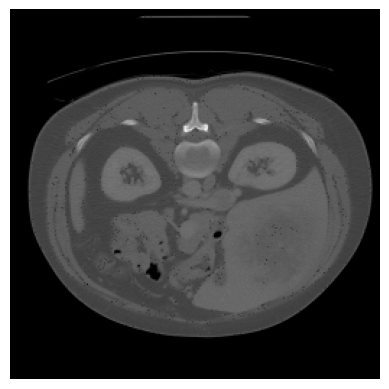

: 

In [10]:
plt.imshow(imgs[0])
plt.axis('off')

In [ ]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)
npz_ts_path = '/media/rohit/mirlproject2/Task03_Liver/MedSAM1/full_ct_data/CT Data/task03_Liver/Npz_files/CT_Abd-Gallbladder/test'
test_npzs = sorted(os.listdir(npz_ts_path))
# random select a test case
npz_idx = np.random.randint(0, len(test_npzs))
npz = np.load(join(npz_ts_path, test_npzs[0]))
imgs = npz['imgs']
gts = npz['gts']

def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

ori_sam_segs = []
medsam_segs = []
bboxes = []
for img, gt in zip(imgs, gts):
    bbox = get_bbox_from_mask(gt)
    bboxes.append(bbox)
    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(img)
    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox, multimask_output=False)
    ori_sam_segs.append(ori_sam_seg[0])
    
    # predict the segmentation mask using the fine-tuned model
    H, W = img.shape[:2]
    resize_img = sam_trans.apply_image(img)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image.to(device)) # (1, 256, 64, 64)
        # convert box to 1024x1024 grid
        bbox = sam_trans.apply_boxes(bbox, (H, W))
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        medsam_segs.append(medsam_seg)

In [10]:
#%% compute the DSC score
ori_sam_segs = np.stack(ori_sam_segs, axis=0)
medsam_segs = np.stack(medsam_segs, axis=0)
ori_sam_dsc = compute_dice_coefficient(gts>0, ori_sam_segs>0)
medsam_dsc = compute_dice_coefficient(gts>0, medsam_segs>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'SAM Finetuned DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.7563 SAM Finetuned DSC: 0.9653


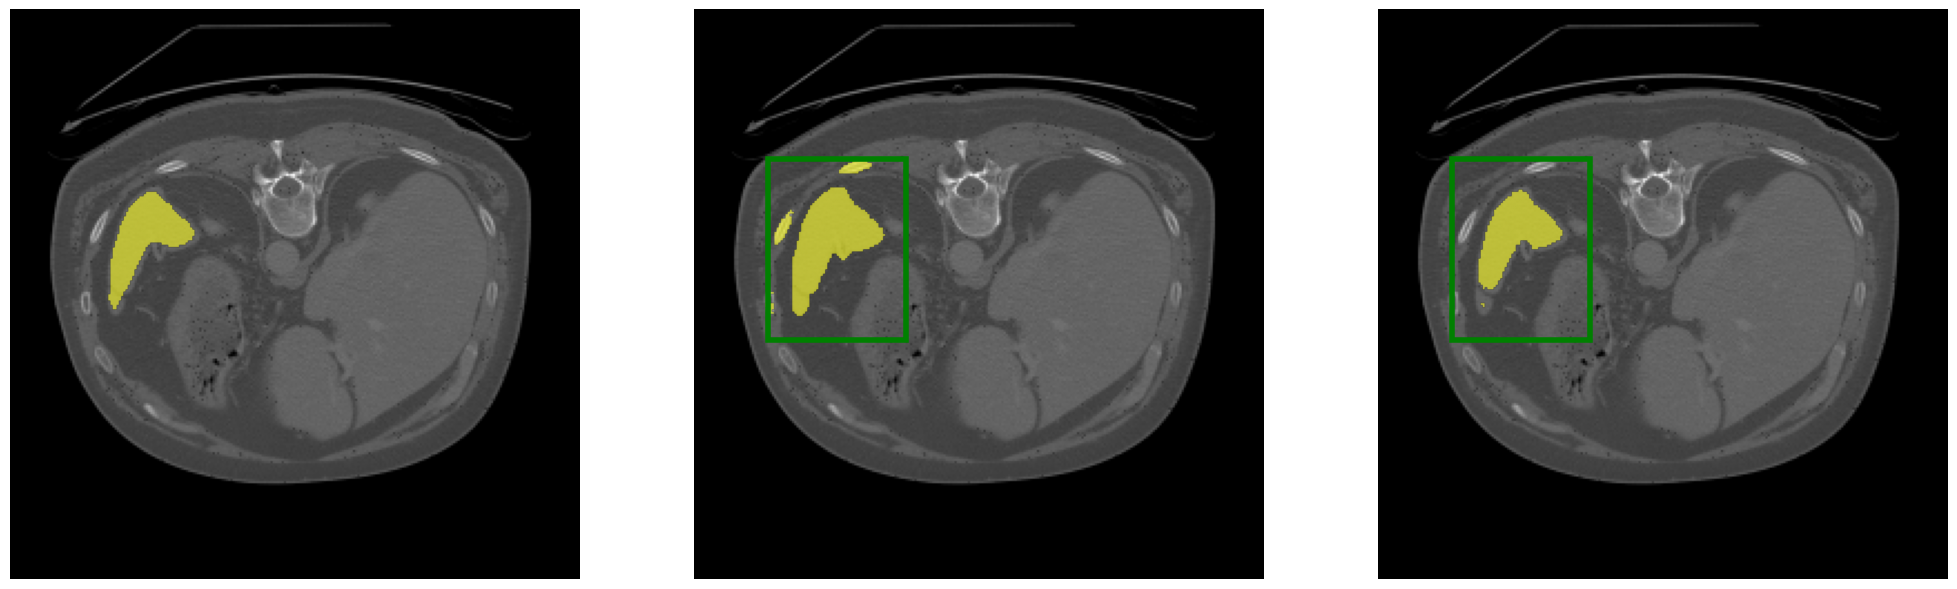

In [15]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=4))    


img_id = int(imgs.shape[0]/2)  # np.random.randint(imgs.shape[0])
_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(imgs[img_id])
show_mask(gts[img_id], axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(imgs[img_id])
show_mask(ori_sam_segs[img_id], axs[1])
show_box(bboxes[img_id], axs[1])
# add text to image to show dice score
#axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(imgs[img_id])
show_mask(medsam_segs[img_id], axs[2])
show_box(bboxes[img_id], axs[2])
# add text to image to show dice score
#axs[2].text(0.5, 0.5, 'SAM Finetuned DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

In [16]:
img_id

27

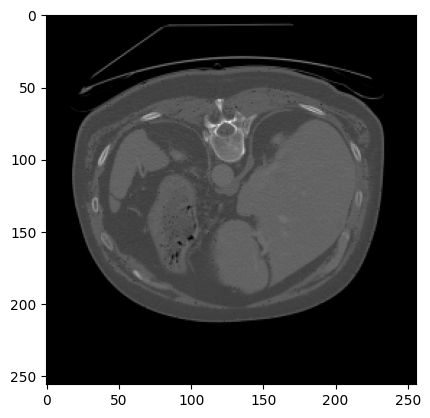

In [13]:
plt.imshow(imgs[img_id])